### Keyword Extractor Tree -- this is an m-ary tree that finds the correct label for description it takes; every node is a keyword and every leaf is a label. Currently it is manually built, hopefully we can optimize it a bit more in the future

In [1]:
import pandas as pd
import lasio
import matplotlib.pyplot as plt

class Node: 
    def __init__(self ,key): 
        self.key = key  
        self.child = [] 

df = pd.read_csv("original_lowered").drop("Unnamed: 0", 1).reset_index(drop=True)
arr = df.label.unique()
cali_arr = ['calibration','diameter','radius']
time_arr = ['time','delta-t','dt']
gr_arr = ['gamma','ray','gr','gamma-ray']
sp_arr = ['sp','spontaneous','potential']
d_arr = ['correction','porosity']
p_arr = ['density','neutron','sonic']
p2_arr = ['dolomite','limestone']
r_arr = ['deep','shallow','medium']
sr_arr = ['a10','a20','ae10','ae20','10in','20in']
mr_arr = ['a30','ae30','30in']
dr_arr = ['a60','a90','ae60','ae90','60in','90in']
root = Node(None)
j = 0
for i in arr:
    root.child.append(Node(i)) 
    root.child[j].child.append(Node(i)) 
    j += 1
for i in cali_arr:
    root.child.append(Node(i)) 
    root.child[j].child.append(Node("caliper")) 
    j += 1
for i in time_arr:
    root.child.append(Node(i)) 
    root.child[j].child.append(Node("sonic travel time")) 
    j += 1
for i in gr_arr:
    root.child.append(Node(i)) 
    root.child[j].child.append(Node("gamma ray")) 
    j += 1
for i in sp_arr:
    root.child.append(Node(i)) 
    root.child[j].child.append(Node("spontaneous potential")) 
    j += 1
root.child.append(Node("photoelectric")) 
root.child[j].child.append(Node("photoelectric effect")) 
j += 1
root.child.append(Node("bit")) 
root.child[j].child.append(Node("bit size")) 
j += 1
for i in sr_arr:
    root.child.append(Node(i)) 
    root.child[j].child.append(Node("shallow resistivity")) 
    j += 1
for i in mr_arr:
    root.child.append(Node(i)) 
    root.child[j].child.append(Node("medium resistivity")) 
    j += 1
for i in dr_arr:
    root.child.append(Node(i)) 
    root.child[j].child.append(Node("deep resistivity")) 
    j += 1
root.child.append(Node("density")) 
k = 0
for i in d_arr:
    root.child[j].child.append(Node(i)) 
    st = "density " + str(i)
    root.child[j].child[k].child.append(Node(st))
    k += 1
root.child.append(Node("porosity")) 
j += 1
k = 0
for i in p_arr:
    root.child[j].child.append(Node(i)) 
    st = str(i) + " porosity"
    root.child[j].child[k].child.append(Node(st))
    k += 1
for i in p2_arr:
    root.child[j].child.append(Node(i)) 
    st = "density porosity"
    root.child[j].child[k].child.append(Node(st))
    k += 1
root.child.append(Node("conductivity"))
j += 1
k = 0
for i in r_arr:
    root.child[j].child.append(Node(i)) 
    st = str(i) + " conductivity"
    root.child[j].child[k].child.append(Node(st))
    k += 1
root.child.append(Node("resistivity")) 
j += 1
k = 0
for i in r_arr:
    root.child[j].child.append(Node(i)) 
    st = str(i) + " resistivity"
    root.child[j].child[k].child.append(Node(st))
    k += 1
for i in sr_arr:
    root.child[j].child.append(Node(i)) 
    st = "shallow resistivity"
    root.child[j].child[k].child.append(Node(st))
    k += 1
for i in mr_arr:
    root.child[j].child.append(Node(i)) 
    st = "medium resistivity"
    root.child[j].child[k].child.append(Node(st))
    k += 1
for i in dr_arr:
    root.child[j].child.append(Node(i)) 
    st = "deep resistivity"
    root.child[j].child[k].child.append(Node(st))
    k += 1
root.child[j].child.append(Node("micro")) 
st = "micro resistivity"
root.child[j].child[k].child.append(Node(st))
root.child.append(Node("res")) 
j += 1
k = 0
for i in r_arr:
    root.child[j].child.append(Node(i)) 
    st = str(i) + " resistivity"
    root.child[j].child[k].child.append(Node(st))
    k += 1
root.child.append(Node("cond")) 
j += 1
k = 0
for i in r_arr:
    root.child[j].child.append(Node(i)) 
    st = str(i) + " conductivity"
    root.child[j].child[k].child.append(Node(st))
    k += 1

#### What the keyword extractor tree looks like

In [2]:
def print_tree(root, indent=0):
    print('   ' * indent + str(root.key))
    for i in root.child:
        print_tree(i, indent + 1)
print_tree(root)

None
   caliper
      caliper
   density correction
      density correction
   sonic travel time
      sonic travel time
   shear sonic
      shear sonic
   sonic porosity
      sonic porosity
   gamma ray
      gamma ray
   spectral gamma ray
      spectral gamma ray
   density porosity
      density porosity
   neutron porosity
      neutron porosity
   photoelectric effect
      photoelectric effect
   deep resistivity
      deep resistivity
   medium resistivity
      medium resistivity
   shallow resistivity
      shallow resistivity
   spontaneous potential
      spontaneous potential
   calibration
      caliper
   diameter
      caliper
   radius
      caliper
   time
      sonic travel time
   delta-t
      sonic travel time
   dt
      sonic travel time
   gamma
      gamma ray
   ray
      gamma ray
   gr
      gamma ray
   gamma-ray
      gamma ray
   sp
      spontaneous potential
   spontaneous
      spontaneous potential
   potential
      spontaneous potential
   photo

### Alias class -- this class takes a path to LAS file as input and returns two dictionaries, one for the parsed mnemonics and one for the mnemonics that can't find a label for. 

In [3]:
def search(root, lst):
    arr = [root]
    arr = [c for node in arr for c in node.child if c]
    for i in lst.split():
        for node in arr:
            if i == node.key:
                return search_child(node,lst)
    return None

def search_child(node, lst):
    if len(node.child) < 1:
        return None
    elif len(node.child) == 1:
        return node.child[0].key
    else:
        for i in lst.split():
            for c in node.child:
                if i == c.key:
                    return search_child(c,lst)
    return None

class Alias(object):
      # Constructor
    def __init__ (self, dictionary = True, keyword_extractor = True):
        self.dictionary = dictionary
        self.keyword_extractor = keyword_extractor
        self.duplicate = []
        self.output, self.not_found = {}, {}
        
    def parse(self, path):
        las = lasio.read(path)
        mnem,desc,unit = [],[],[]
        for key in las.keys():
            mnem.append(key.lower())
            if str(las.curves[key].descr) == "" and str(las.curves[key].value) == "":
                desc.append("None")
            else:
                desc.append(str(las.curves[key].descr).lower())
            if str(las.curves[key].unit) == "":
                unit.append("Unitless")
            else:
                unit.append(str(las.curves[key].unit).lower())
        if self.dictionary == True:
            self.dictionary_parse(mnem)
        if self.keyword_extractor == True:
            self.keyword_parse(mnem, desc)
        return self.output, self.not_found
    
    def dictionary_parse(self, mnem):
        df = pd.read_csv("comprehensive_dictionary").drop("Unnamed: 0", 1).reset_index(drop=True)
        dic = df.apply(lambda x: x.astype(str).str.lower())
        index = 0
        for i in mnem:
            if i in dic.mnemonics.unique():
                key = dic.loc[dic['mnemonics'] == i, 'label'].iloc[0] # can be reduced?
                self.output[i] = key
                self.duplicate.append(index)
            index += 1

    def keyword_parse(self, mnem, desc):
        pwls = pd.read_csv("pwls.csv").drop("Unnamed: 0", 1)
        new_desc = [v for i, v in enumerate(desc) if i not in self.duplicate]
        new_mnem = [v for i, v in enumerate(mnem) if i not in self.duplicate]
        index = 0
        for i in new_desc:
            key = search(root, i)
            if key == None:
                if i in pwls['abbrev']:
                    self.output[new_mnem[index]] = pwls.loc[pwls['abbrev'] == i].index[0]
                else:
                    self.not_found[new_mnem[index]] = i
            else:                    
                self.output[new_mnem[index]] = key
            index += 1

### Example using the Alias class

   mnemonic                                        description  \
0      dept                           DEPTH (BOREHOLE) {F11.4}   
1      ae20  Array Induction Resistivity Environmentally Co...   
2      ae30  Array Induction Resistivity Environmentally Co...   
3      ae60  Array Induction Resistivity Environmentally Co...   
4     ahf10  Array Induction Four Foot Resistivity A10 {F12.3}   
5     ahf20  Array Induction Four Foot Resistivity A20 {F12.3}   
6     ahf30  Array Induction Four Foot Resistivity A30 {F12.3}   
7     ahf60  Array Induction Four Foot Resistivity A60 {F12.3}   
8     ahf90  Array Induction Four Foot Resistivity A90 {F12.3}   
9   ahfco60  Array Induction Four Foot Conductivity A60 {F1...   
10  ahfco90  Array Induction Four Foot Conductivity A90 {F1...   
11    aho10   Array Induction One Foot Resistivity A10 {F12.3}   
12    aho20   Array Induction One Foot Resistivity A20 {F12.3}   
13    aho30   Array Induction One Foot Resistivity A30 {F12.3}   
14    aho6

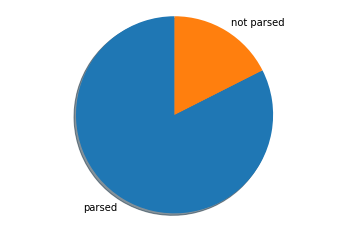

In [4]:
path = "" # las file = "3725634A.las"
a = Alias()
parsed, not_found = a.parse(path)
las = lasio.read(path)
l,l2,l3 = [],[],[]
for key, value in parsed.items():
    l.append(key)
    l2.append(str(las.curves[key].descr))
    l3.append(value)
output_df = pd.DataFrame(
    {'mnemonic': l,
     'description': l2,
     'parsed_mnemonic': l3
    })
l,l2 = [],[]
for key, value in not_found.items():
    l.append(key)
    l2.append(str(las.curves[key].descr))
output_df2 = pd.DataFrame(
    {'mnemonic': l,
     'description': l2
    })
print(output_df)
print("*"*10,"Not Found", "*"*10)
print(output_df2)
print("{}/{}".format(len(parsed),len(not_found)+len(parsed)))
labels = ["parsed","not parsed"]
sizes = [len(parsed),len(not_found)]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, shadow=True, startangle=90)
ax1.axis('equal')
plt.show()